# Gaussian Distribution 

### Imports and helpers

In [29]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from math import comb, exp, pi

np.random.seed(0)

def binomial_pmf(N, p=0.5):
    return np.array([comb(N, k) * p**k * (1-p)**(N-k) for k in range(N+1)])

def tv_distance(p, q):
    p, q = np.asarray(p), np.asarray(q)
    return 0.5 * np.abs(p - q).sum()

def summarize_and_plot(k, N, title="", ideal=None):
    shots = len(k)
    emp = np.array([np.mean(k == i) for i in range(N+1)])
    ideal = binomial_pmf(N, 0.5) if ideal is None else ideal
    mu, var = k.mean(), k.var()
    tvd = tv_distance(emp, ideal)

    print(f"N={N}, shots(used)={shots}")
    print(f"  mean: {mu:.4f}   (ideal {N/2:.4f})")
    print(f"  var:  {var:.4f}  (ideal {N/4:.4f})")
    print(f"  TVD:  {tvd:.4e}")

    xs = np.arange(N+1)
    plt.figure(figsize=(7.5,3.8))
    plt.bar(xs, ideal, alpha=0.35, label="Ideal Binomial")
    plt.bar(xs, emp,   alpha=0.65, label="Empirical (noisy)")
    plt.xlabel("Final bin index k (# right moves)")
    plt.ylabel("Probability")
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()


### Hardware-style noise parameters & channels 

In [30]:
def noise_params(
    T1=80e-6, T2=100e-6,         # coherence times
    t_1q=35e-9, t_2q=200e-9,     # gate durations
    p1=1.5e-3, p2=1.5e-2,        # depol per 1q/2q gate
    p_ro=0.02                    # readout assignment error
):
    # Amplitude- and phase-damping probabilities for each gate type
    def ad_prob(t): return 1.0 - exp(-t / T1)
    Tphi_inv = max(0.0, (1.0/T2) - (1.0/(2.0*T1)))
    Tphi = 1.0 / (Tphi_inv + 1e-16) if Tphi_inv > 0 else 1e9
    def pd_prob(t): return 1.0 - exp(-t / Tphi)

    return {
        "p1": p1, "p2": p2,
        "ad_1q": ad_prob(t_1q), "pd_1q": pd_prob(t_1q),
        "ad_2q": ad_prob(t_2q), "pd_2q": pd_prob(t_2q),
        "p_ro": p_ro
    }

def add_1q_noise(w, pars):
    qml.DepolarizingChannel(pars["p1"], wires=w)
    qml.AmplitudeDamping(pars["ad_1q"], wires=w)
    qml.PhaseDamping(pars["pd_1q"], wires=w)

def add_2q_noise(w1, w2, pars):
    # Approximate 2q noise by applying single-qubit channels to both qubits
    # (pennylane also has TwoQubitDepolarizingChannel; use it if available in your version)
    qml.DepolarizingChannel(pars["p2"]/2, wires=w1)
    qml.DepolarizingChannel(pars["p2"]/2, wires=w2)
    qml.AmplitudeDamping(pars["ad_2q"], wires=w1)
    qml.AmplitudeDamping(pars["ad_2q"], wires=w2)
    qml.PhaseDamping(pars["pd_2q"], wires=w1)
    qml.PhaseDamping(pars["pd_2q"], wires=w2)


### Noisy QGB builder + run helpers

In [31]:
def peg_once_noisy(bin_wires, coin, j, pars):
    # CSWAP then write-back CNOT
    qml.CSWAP(wires=[coin, bin_wires[j], bin_wires[j+1]])
    add_2q_noise(coin, bin_wires[j], pars)
    add_2q_noise(coin, bin_wires[j+1], pars)

    qml.CNOT(wires=[bin_wires[j+1], coin])
    add_2q_noise(bin_wires[j+1], coin, pars)

def thetas_schedule(N, a=0.0, b=0.0):
    center = 0.5*(N-1)
    return [pi/2 + a + b*(ell - center) for ell in range(N)]

def qgb_noisy_qnode(N, pars, thetas=None, shots=20_000):
    thetas = thetas or [pi/2]*N
    coins = [f"c{ell}" for ell in range(N)]
    bins  = [f"b{i}" for i in range(N+1)]
    dev   = qml.device("default.mixed", wires=coins+bins, shots=shots)

    @qml.qnode(dev)
    def circuit():
        # init ball
        qml.PauliX(bins[0])
        for ell in range(N):
            qml.RX(thetas[ell], wires=coins[ell])
            add_1q_noise(coins[ell], pars)
            for j in range(ell, -1, -1):     # RIGHT → LEFT
                peg_once_noisy(bins, coins[ell], j, pars)
        # emulate assignment error
        for w in bins:
            qml.BitFlip(pars["p_ro"], wires=w)
        return qml.sample(wires=bins)

    return circuit

def postselect_and_index(samples):
    # Keep only rows with exactly one '1'; return indices and acceptance rate
    weights = samples.sum(axis=1)
    mask = (weights == 1)
    acc = mask.mean()
    valid = samples[mask]
    k = np.argmax(valid, axis=1)
    return k, acc


### Results 

In [ ]:
# Choose N and a hardware-like noise setting
N = 6
pars = noise_params(
    T1=80e-6, T2=100e-6,
    t_1q=35e-9, t_2q=200e-9,
    p1=1.5e-3, p2=1.5e-2,
    p_ro=0.02
)

shots = 40_000
circ = qgb_noisy_qnode(N, pars, thetas=[pi/2]*N, shots=shots)
samps = circ()                                   # shape: (shots, N+1)
k_valid, acc = postselect_and_index(samps)

print(f"Post-selection acceptance: {acc*100:.2f}% (kept {len(k_valid)} of {shots})")
summarize_and_plot(k_valid, N, title=f"Noisy QGB baseline (N={N})")


## Further Optimisation 

In [6]:
def evaluate_schedule(N, pars, a, b, shots_eval=15_000):
    thetas = thetas_schedule(N, a=a, b=b)
    circ   = qgb_noisy_qnode(N, pars, thetas=thetas, shots=shots_eval)
    samps  = circ()
    k_valid, acc = postselect_and_index(samps)
    emp = np.array([np.mean(k_valid == i) for i in range(N+1)])
    tvd = tv_distance(emp, binomial_pmf(N))
    return tvd, acc, k_valid

# coarse grid
A = np.linspace(-0.25, 0.25, 11)     # radians
B = np.linspace(-0.06, 0.06, 13)
best = {"tvd": 1e9, "a": None, "b": None, "acc": 0, "k": None}
for a in A:
    for b in B:
        tvd, acc, k = evaluate_schedule(N, pars, a, b, shots_eval=10_000)
        if tvd < best["tvd"]:
            best = {"tvd": tvd, "a": a, "b": b, "acc": acc, "k": k}

print(f"Coarse best: TVD={best['tvd']:.4f}  a={best['a']:.4f}  b={best['b']:.4f}  acc={best['acc']*100:.1f}%")

# refine around the coarse best
da = 0.05; db = 0.02
A_ref = np.linspace(best["a"]-da, best["a"]+da, 9)
B_ref = np.linspace(best["b"]-db, best["b"]+db, 9)

for a in A_ref:
    for b in B_ref:
        tvd, acc, k = evaluate_schedule(N, pars, a, b, shots_eval=15_000)
        if tvd < best["tvd"]:
            best = {"tvd": tvd, "a": a, "b": b, "acc": acc, "k": k}

print(f"Refined best: TVD={best['tvd']:.4f}  a={best['a']:.4f}  b={best['b']:.4f}  acc={best['acc']*100:.1f}%")


Coarse best: TVD=0.0074  a=0.0000  b=0.0100  acc=84.0%
Refined best: TVD=0.0074  a=0.0000  b=0.0100  acc=84.0%


### Final results 

Acceptance  baseline: 83.86%   optimized: 84.32%
N=3, shots(used)=33542
  mean: 1.4799   (ideal 1.5000)
  var:  0.7775  (ideal 0.7500)
  TVD:  1.3938e-02


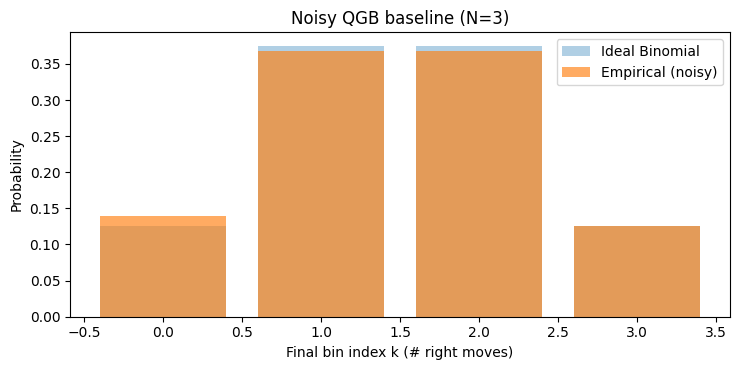

N=3, shots(used)=33729
  mean: 1.4786   (ideal 1.5000)
  var:  0.7776  (ideal 0.7500)
  TVD:  1.4046e-02


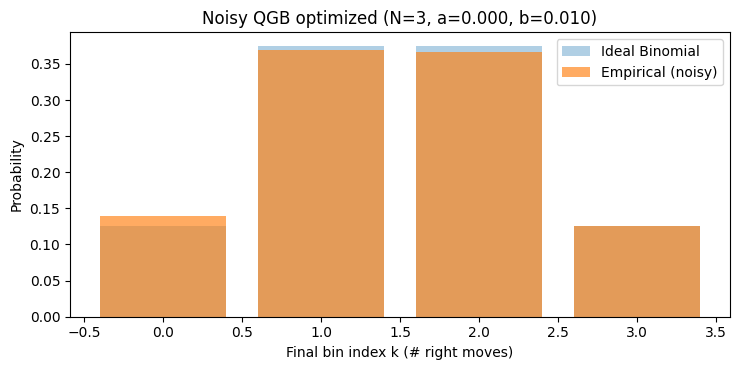

In [7]:
SHOTS_FINAL = 40_000

# Baseline again for fair comparison
circ_base = qgb_noisy_qnode(N, pars, thetas=[pi/2]*N, shots=SHOTS_FINAL)
k_base, acc_base = postselect_and_index(circ_base())

# Optimized
thetas_opt = thetas_schedule(N, a=best["a"], b=best["b"])
circ_opt   = qgb_noisy_qnode(N, pars, thetas=thetas_opt, shots=SHOTS_FINAL)
k_opt, acc_opt = postselect_and_index(circ_opt())

print(f"Acceptance  baseline: {acc_base*100:.2f}%   optimized: {acc_opt*100:.2f}%")

# Stats + plots
summarize_and_plot(k_base, N, title=f"Noisy QGB baseline (N={N})")
summarize_and_plot(k_opt,  N, title=f"Noisy QGB optimized (N={N}, a={best['a']:.3f}, b={best['b']:.3f})")


# Exponential Distribution (noisy)

### Imports & helpers

In [8]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from math import ceil, log2, exp

np.random.seed(0)

def bits_to_int(bits, endian="msb"):
    if bits.ndim == 1:
        return bits.astype(int)
    m = bits.shape[1]
    if endian == "msb":
        weights = 1 << np.arange(m-1, -1, -1)
    else:
        weights = 1 << np.arange(m)
    return (bits * weights).sum(axis=1).astype(int)

def tv_distance(p, q): return 0.5*np.abs(np.asarray(p)-np.asarray(q)).sum()

def summarize_vs_ideal(ints, ideal, title=""):
    N = len(ideal)-1
    counts = np.bincount(ints, minlength=N+1)[:N+1]
    emp = counts / counts.sum()
    xs = np.arange(N+1)
    mu_e, var_e = (xs*emp).sum(), (xs**2*emp).sum() - (xs*emp).sum()**2
    mu_i, var_i = (xs*ideal).sum(), (xs**2*ideal).sum() - (xs*ideal).sum()**2
    tvd = tv_distance(emp, ideal)
    print(f"N={N}, shots={len(ints)}  mean {mu_e:.4f} ({mu_i:.4f})  var {var_e:.4f} ({var_i:.4f})  TVD {tvd:.4e}")
    plt.figure(figsize=(7.6,3.8))
    plt.bar(xs, ideal, alpha=0.35, label="Ideal")
    plt.bar(xs, emp,   alpha=0.65, label="Noisy empirical")
    plt.xlabel("k"); plt.ylabel("Probability"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()


### Target & pre-compensation

In [9]:
def exp_pmf(N, lam):
    k = np.arange(N+1)
    w = np.exp(-lam * k)
    p = w / w.sum()
    return p

def precomp_exponential(N, lam_target, lam_prep=None, alpha=1.0):
    lam_prep = lam_target if lam_prep is None else lam_prep
    base = exp_pmf(N, lam_prep)
    q = base**alpha
    q = q / q.sum()
    return q


### Hardware-style noise model (same shape as above)

In [10]:
def noise_params(
    T1=80e-6, T2=100e-6, t_1q=35e-9,
    p1=1.5e-3, p_ro=0.02, depth=8
):
    # Probability per 1q-layer; emulate circuit depth with 'depth' repeats
    def ad_prob(t): return 1.0 - exp(-t / T1)
    Tphi_inv = max(0.0, (1.0/T2) - (1.0/(2.0*T1)))
    Tphi = 1.0/(Tphi_inv + 1e-16) if Tphi_inv>0 else 1e9
    def pd_prob(t): return 1.0 - exp(-t / Tphi)
    return {"p1":p1, "ad":ad_prob(t_1q), "pd":pd_prob(t_1q), "p_ro":p_ro, "depth":int(depth)}

def apply_1q_noise_all(wires, pars):
    for _ in range(pars["depth"]):
        for w in wires:
            qml.DepolarizingChannel(pars["p1"], wires=w)
            qml.AmplitudeDamping(pars["ad"], wires=w)
            qml.PhaseDamping(pars["pd"], wires=w)


### Noisy exponential sampler (all to all)

In [11]:
def exp_noisy_sampler(N, lam_target=0.35, lam_prep=None, alpha=1.0, pars=None, shots=50_000, use_mottonen=False):
    m = max(1, ceil(log2(N+1))); D = 2**m
    q = precomp_exponential(N, lam_target, lam_prep=lam_prep, alpha=alpha)
    amp = np.zeros(D, dtype=complex); amp[:N+1] = np.sqrt(q)
    pars = pars or noise_params()

    dev = qml.device("default.mixed", wires=list(range(m)), shots=shots)

    @qml.qnode(dev)
    def circuit():
        if use_mottonen:
            qml.MottonenStatePreparation(amp, wires=range(m))
        else:
            qml.QubitStateVector(amp, wires=range(m))
        apply_1q_noise_all(range(m), pars)
        for w in range(m):
            qml.BitFlip(pars["p_ro"], wires=w)   # readout error
        return qml.sample(wires=range(m))
    return circuit, q


### Baseline vs optimized (grid search λ_prep, α) 

N=8, shots=40000  mean 2.1126 (1.9833)  var 4.6715 (4.2917)  TVD 2.1712e-02


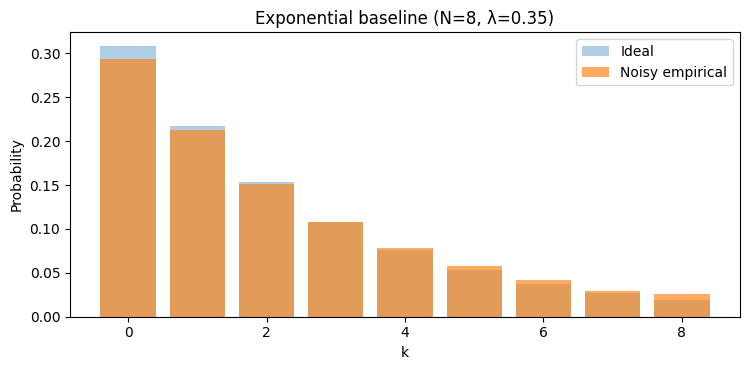

Best precomp: TVD=0.0066  lam_prep=0.1500  alpha=0.900
N=8, shots=40000  mean 3.1476 (3.1217)  var 6.2120 (6.1963)  TVD 7.2128e-03


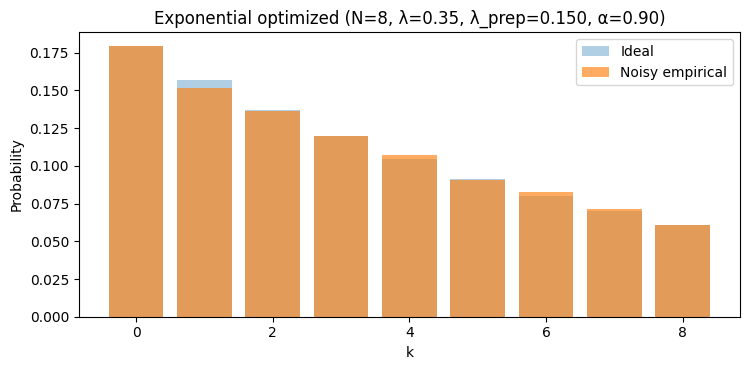

In [15]:
# Settings
N, LAM = 8, 0.35
pars = noise_params(T1=80e-6, T2=100e-6, t_1q=35e-9, p1=1.5e-3, p_ro=0.02, depth=8)

# Baseline (no precompensation)
circ_base, ideal = exp_noisy_sampler(N, lam_target=LAM, lam_prep=LAM, alpha=1.0, pars=pars, shots=40_000)
bits = circ_base()
ints_msb = bits_to_int(bits, "msb"); ints_lsb = bits_to_int(bits, "lsb")
bad_msb = np.count_nonzero(ints_msb > N); bad_lsb = np.count_nonzero(ints_lsb > N)
ints_base = ints_msb if bad_msb <= bad_lsb else ints_lsb
summarize_vs_ideal(ints_base, ideal, title=f"Exponential baseline (N={N}, λ={LAM})")

# Grid search
LAM_GRID = np.linspace(LAM-0.20, LAM+0.20, 9)
ALPHA_GRID = np.linspace(0.85, 1.25, 9)
best = {"tvd": 1e9, "lam_prep": None, "alpha": None, "ints": None}

for lam_p in LAM_GRID:
    for a in ALPHA_GRID:
        circ, ideal_target = exp_noisy_sampler(N, lam_target=LAM, lam_prep=lam_p, alpha=a, pars=pars, shots=15_000)
        b = circ()
        im = bits_to_int(b, "msb"); il = bits_to_int(b, "lsb")
        ints = im if np.count_nonzero(im > N) <= np.count_nonzero(il > N) else il
        counts = np.bincount(ints, minlength=N+1)[:N+1]; emp = counts / counts.sum()
        tvd = tv_distance(emp, ideal_target)  # compare to *target* (λ)
        if tvd < best["tvd"]:
            best = {"tvd": tvd, "lam_prep": lam_p, "alpha": a, "ints": ints}

print(f"Best precomp: TVD={best['tvd']:.4f}  lam_prep={best['lam_prep']:.4f}  alpha={best['alpha']:.3f}")

# Final rerun with more shots
circ_opt, ideal_target = exp_noisy_sampler(N, lam_target=LAM, lam_prep=best["lam_prep"], alpha=best["alpha"], pars=pars, shots=40_000)
b = circ_opt()
im = bits_to_int(b, "msb"); il = bits_to_int(b, "lsb")
ints_opt = im if np.count_nonzero(im > N) <= np.count_nonzero(il > N) else il
summarize_vs_ideal(ints_opt, ideal_target, title=f"Exponential optimized (N={N}, λ={LAM}, λ_prep={best['lam_prep']:.3f}, α={best['alpha']:.2f})")


#   Hadamard quantum walk (noisy)

### Classical Hadamard-walk PMF

In [20]:
def hadamard_qw_distribution(T, init_coin=("sym",)):
    L = 2*T + 1; off = T
    if init_coin and init_coin[0] == "sym":
        alpha, beta = 1/np.sqrt(2), 1j/np.sqrt(2)
    else:
        alpha, beta = init_coin
    psi0 = np.zeros(L, dtype=complex); psi1 = np.zeros(L, dtype=complex)
    psi0[off], psi1[off] = alpha, beta
    H = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
    for _ in range(T):
        a, b = psi0.copy(), psi1.copy()
        psi0 = H[0,0]*a + H[0,1]*b
        psi1 = H[1,0]*a + H[1,1]*b
        n0 = np.zeros_like(psi0); n1 = np.zeros_like(psi1)
        n0[1:]  += psi0[:-1]   # coin=0 → right
        n1[:-1] += psi1[1:]    # coin=1 → left
        psi0, psi1 = n0, n1
    p = (np.abs(psi0)**2 + np.abs(psi1)**2)
    p = p / p.sum()
    return p


### Noisy sampler (+ α-precompensation)

In [21]:
def qwalk_noisy_sampler(T, alpha=1.0, pars=None, shots=50_000, use_mottonen=False):
    p = hadamard_qw_distribution(T)
    N = len(p) - 1; m = max(1, ceil(log2(N+1))); D = 2**m
    q = (p**alpha); q /= q.sum()
    amp = np.zeros(D, dtype=complex); amp[:N+1] = np.sqrt(q)
    pars = pars or noise_params()

    dev = qml.device("default.mixed", wires=list(range(m)), shots=shots)

    @qml.qnode(dev)
    def circuit():
        if use_mottonen:
            qml.MottonenStatePreparation(amp, wires=range(m))
        else:
            qml.QubitStateVector(amp, wires=range(m))
        apply_1q_noise_all(range(m), pars)
        for w in range(m):
            qml.BitFlip(pars["p_ro"], wires=w)
        return qml.sample(wires=range(m))
    return circuit, p


### Baseline vs optimized (grid search α)

N=16, shots=40000  mean 7.5736 (8.0000)  var 15.1166 (19.1250)  TVD 2.4005e-01


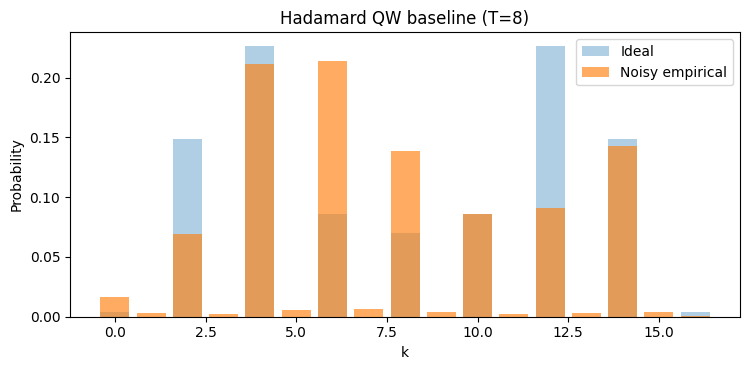

Best α: TVD=0.0380  α=1.150
N=16, shots=40000  mean 7.9403 (8.0000)  var 19.5743 (19.1250)  TVD 3.8609e-02


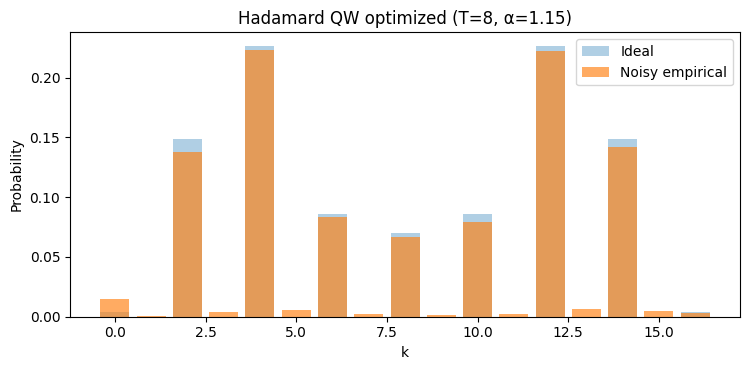

In [26]:
# Settings
T = 8
pars = noise_params(T1=80e-6, T2=100e-6, t_1q=35e-9, p1=1.5e-3, p_ro=0.02, depth=8)

# Baseline (α=1)
circ_base, p_target = qwalk_noisy_sampler(T, alpha=1.0, pars=pars, shots=40_000)
bits = circ_base()
N = len(p_target) - 1
im = bits_to_int(bits, "msb"); il = bits_to_int(bits, "lsb")
ints_base = im if np.count_nonzero(im > N) <= np.count_nonzero(il > N) else il
summarize_vs_ideal(ints_base, p_target, title=f"Hadamard QW baseline (T={T})")

# Grid search for α
best = {"tvd": 1e9, "alpha": None, "ints": None}
for a in np.linspace(0.85, 1.25, 17):
    circ, p_t = qwalk_noisy_sampler(T, alpha=a, pars=pars, shots=20_000)
    b = circ()
    im = bits_to_int(b, "msb"); il = bits_to_int(b, "lsb")
    ints = im if np.count_nonzero(im > N) <= np.count_nonzero(il > N) else il
    counts = np.bincount(ints, minlength=N+1)[:N+1]; emp = counts / counts.sum()
    tvd = tv_distance(emp, p_t)
    if tvd < best["tvd"]:
        best = {"tvd": tvd, "alpha": a, "ints": ints}

print(f"Best α: TVD={best['tvd']:.4f}  α={best['alpha']:.3f}")

# Final rerun with more shots
circ_opt, p_t = qwalk_noisy_sampler(T, alpha=best["alpha"], pars=pars, shots=40_000)
b = circ_opt()
im = bits_to_int(b, "msb"); il = bits_to_int(b, "lsb")
ints_opt = im if np.count_nonzero(im > N) <= np.count_nonzero(il > N) else il
summarize_vs_ideal(ints_opt, p_t, title=f"Hadamard QW optimized (T={T}, α={best['alpha']:.2f})")
